Diego Escobedo

# 6.S083 / 18.S190 Spring 2020: Problem set 3

Submission deadline: Tuesday April 21, 2020 at 11:59pm.


In this problem set, we will develop our first proper model that exhibits an **epidemic
outbreak**.

We will develop a **stochastic** (probabilistic) model of an infection propagating in a population  that is **well mixed**, i.e. in which everyone is in contact with everyone else.
An example of this would be a small school or university in which people are
constantly moving around and interacting with each other.

As usual, we will make modelling assumptions that allow us to reach the goal as fast and simply as possible.

The model is an **individual-based** or **agent-based** model -- in other words,
we explicitly keep track of each individual in the population and what their
infection status is. However, we will not keep track of their position in space;
we will just assume that there is some mechanism by which they interact with
other individuals which we do not include in the model (for now).

## Exercise 1: Modelling the spread of an infection or rumour

In this exercise we will model the spread of an infection or rumour in which
there is no recovery via a stochastic model, which we will implement in a Monte Carlo
simulation (i.e. a simulation that involves generating random numbers).

We will call the individuals **agents**.


1. Julia has a data type called an [**enumerated type**](https://en.wikipedia.org/wiki/Enumerated_type). Variables of this type can only take one of a pre-defined set of values; we will use this to model the possible internal state of an agent.

    The code to define an enum is as follows:

    ```julia
    @enum InfectionStatus S I R
    ```

    This defines a new type `InfectionStatus`, as well as names `S`, `I` and `R` that are the only possible values that a variable of this type can take.

    Define a variable `x` equal to `S`. What is its type?

In [5]:
@enum InfectionStatus S I R
x = S
typeof(x)

Enum InfectionStatus:
S = 0
I = 1
R = 2

2. Convert `x` to an integer using the `Int` function. What value does it have? What values do `I` and `R` have?

In [9]:
println(Int(x))
y = I
println(Int(y))
z = R
println(Int(z))

0
1
2


3. Take $N=100$. Make an array `agents` whose $i$th entry is the status of agent number $i$. Make them all initially susceptible.

In [23]:
N = 100
agents = [S for i in 1:N];

4. Now choose a single agent at random and make it infectious. (Hint: Use the
    `rand` function with a range to choose the index of the infectious agent.)

In [24]:
rand_index = rand((1:N))
agents[rand_index] = I;

5. Write a function `step!` that takes a `Vector` `agents` and a probability `p_I`
as arguments.  This function may *modify* the content of `agents` to implement one step of the infection dynamics.

    1. Choose an agent $i$ at random.
    2. If $i$ is not infectious then nothing happens on this step so you can just `return` from the function.
    3. Choose another agent $j$ at random. Make sure that $i \neq j$. To do so, repeat this
    choice *until* $i \neq j$.
    4. If $j$ is not infected then $i$ infects $j$ with probability $p_I$.

In [26]:
function step!(agents::Vector, p_I::Float64)
    rand_index = rand((1:length(agents)))
    if agents[rand_index] != I
        return
    end
    infected_index = rand((1:length(agents)))
    while infected_index == rand_index
        infected_index = rand((1:length(agents)))
    end
    if agents[infected_index] != I
        if rand() < p_I
            agents[infected_index] = I
        end
    end
end

step! (generic function with 1 method)

6. Write a function `sweep!`. It runs `step!` $N$ times, where $N$ is the number of agents. Thus each agent acts, on average, once per sweep. One sweep is thus the unit
of time in our Monte Carlo simulation.

In [27]:
function sweep!(agents::Vector, p_I::Float64)
    for i in 1:length(agents)
        step!(agents, p_I)
    end
end

sweep! (generic function with 1 method)

7. Write a function `infection_simulation`. It should take $N$ and $p_I$ as arguments,
as well as $T$, the total number of steps.

    1. First generate the `Vector` `agents` of length $N$ and a `Vector` `Is` to store
    the number of infectious individuals at each step.

    2. Run `sweep!` a number $T$ of times. Calculate the total number of infectious
    agents at the end of each step and store that number in `Is`.

    3. Return `Is` as the output of the function.

In [37]:
function infection_simulation(N::Int64,p_i::Float64,T::Int64)
    agents = [S for i in 1:N]
    init_infected = rand((1:N))
    agents[init_infected] = I
    Is = [0]
    for i in 1:T
        sweep!(agents,p_i)
        inf = count(agents .== I)
        push!(Is,inf)
    end
    return Is
end

infection_simulation (generic function with 1 method)

8. Run your simulation 50 times with $N=100$ and collect the data in a `Vector` of `Vector`s called `results`, using $p_I = 0.02$ and $T = 1000$.

    Plot each of the 50 graphs on the same plot using transparency 0.5.

In [44]:
using Plots
num_runs = 50
N = 100
p_i = 0.02
T = 1000
results = Vector[]
for i in 1:num_runs
    result = infection_simulation(N,p_i,T)
    push!(results,result)
end

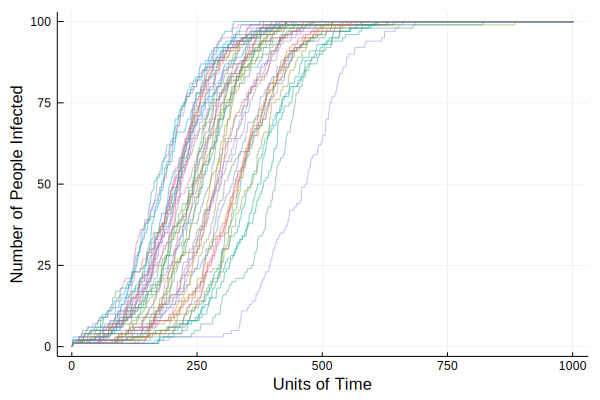

In [87]:
p = plot(leg=false)
xlabel!("Units of Time")
ylabel!("Number of People Infected")
for series in results
    plot!(series,alpha=0.5)
end
p

9. Calculate the mean trajectory using the `mean` function applied to `results`. [This "just works" since `mean` is implmented in a generic way!] Add it to the plot using a heavier line.

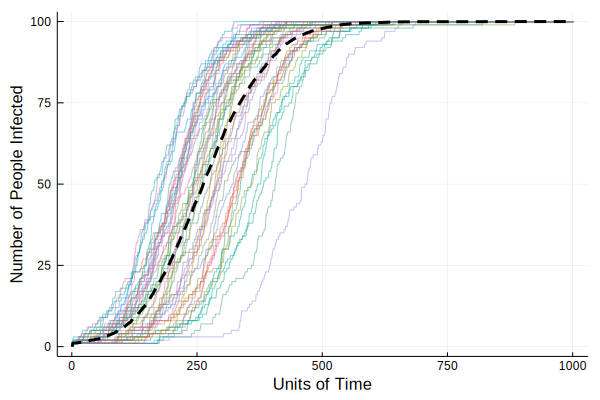

In [88]:
using Statistics
using StatsBase
mean_traj = mean(results)
plot!(mean_traj,lw=3,linestyle=:dash,color=:black)

10. Calculate the standard deviation $\sigma$ of $I$ at each step. [This should thus be a *vector.] Add this to the plot using **error bars**, using the option `yerr=σ` in the plot command; use transparency.

    This should confirm that the distribution of $I$ at each step is pretty wide!

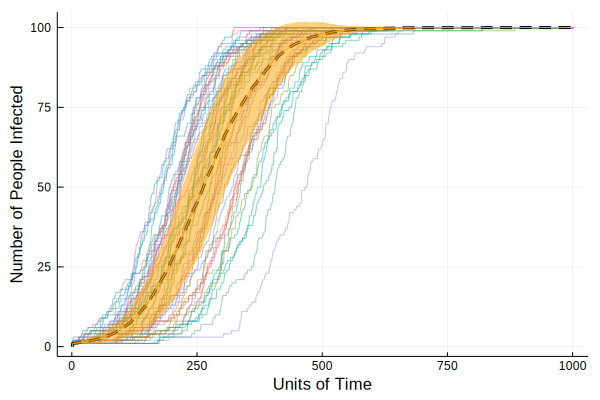

In [89]:
σ = Float64[]
for timestep in 1:T+1
    ts_mean = mean_traj[timestep]
    centered_squared_sum = 0.0
    for series in results
        centered_squared_sum += (series[timestep]-ts_mean)^2
    end
    ts_sigma = sqrt(centered_squared_sum/N)
    push!(σ, ts_sigma)
end
plot!(mean_traj,ribbon = σ,fillalpha=.5,color=:orange)

11. You should see that the mean behaves in a similar way to what we saw in lectures using a *deterministic* model. So what is the deterministic model possibly describing, in terms of the stochastic model?

Maybe the deterministic model is an interpretation of a single possible run of the stochastic model. It is a good approximation of what the stochastic one might look like.

## Exercise 2: Agent type

Suppose we want to track more information about each agent, e.g. how many other agents were infected by that agent. We could just create an additional array with that information in, but we will need to pass that around and will start to lose track of what belongs together.

Instead a good solution is to define a custom composite type.


1. Define a mutable type `Agent` as follows:

    ```jl
    mutable struct Agent
        status::InfectionStatus
        num_infected::Int
    end
    ```

In [90]:
mutable struct Agent
    status::InfectionStatus
    num_infected::Int
end

2. Define a method of the constructor of `Agent` that takes no arguments and sets the status to `S` and
the number infected to 0.

In [95]:
Agent() = Agent(S, 0)

Agent

3. Make an array `agents` of `Agent`s. Set the first one's infection status to `I`.

In [96]:
N = 100
agents = [Agent() for i in 1:N]
agents[1].status = I

I::InfectionStatus = 1

4. Rewrite your code from Exercise 1 to use the new `Agent` type. Now when your functions accept an `agents`
vector, they should assume that that represents a `Vector` of `Agent` objects.

    You can enforce this using a function signature like

    ```jl
    function f(agents::Vector{Agent})
    end
    ```
5. Update an agent's `num_infected` field whenever it infects another agent.

In [119]:
function step!(agents::Vector{Agent}, p_I::Float64)
    rand_index = rand((1:length(agents)))
    if agents[rand_index].status != I
        return
    end
    infected_index = rand((1:length(agents)))
    while infected_index == rand_index
        infected_index = rand((1:length(agents)))
    end
    if agents[infected_index].status == S
        if rand() < p_I
            agents[infected_index].status = I
            agents[rand_index].num_infected += 1
        end
    end
end

step! (generic function with 2 methods)

In [120]:
function sweep!(agents::Vector{Agent}, p_I::Float64)
    for i in 1:length(agents)
        step!(agents, p_I)
    end
end

sweep! (generic function with 2 methods)

In [121]:
function infection_simulation(N::Int64,p_i::Float64,T::Int64)
    agents = [Agent() for i in 1:N]
    init_infected = rand((1:N))
    agents[init_infected].status = I
    Is = [0]
    for i in 1:T
        sweep!(agents,p_i)
        inf = count([agent.status == I for agent in agents])
        push!(Is,inf)
    end
    return agents, Is
end

infection_simulation (generic function with 2 methods)

6. At the end of the simulation, extract the probability distribution of the "number of agents infected", using your code from Exercise 1 of Problem Set 2.

In [122]:
function counts(data)
    counts = Dict()
    for elem in data     
        if haskey(counts,elem)
            counts[elem] += 1
        else
            counts[elem] = 1
        end
    end
    ks = collect(keys(counts))
    vs = collect(values(counts))
    p = sortperm(ks)
    return ks[p], vs[p]
end

counts (generic function with 1 method)

In [123]:
function probability_distribution(data)
    ks, vs = counts(data)
    tot = sum(vs)
    probs = vs./tot
    return ks, probs
end

probability_distribution (generic function with 1 method)

In [124]:
N = 10000
p_i = 0.02
T = 10000
agents, Is = infection_simulation(N,p_i,T)
data = [x.num_infected for x in agents]
ks,probs = probability_distribution(data);

7. Plot the probability distribution. What kind of distribution does it seem to be? You will need to think about how to visualize this.

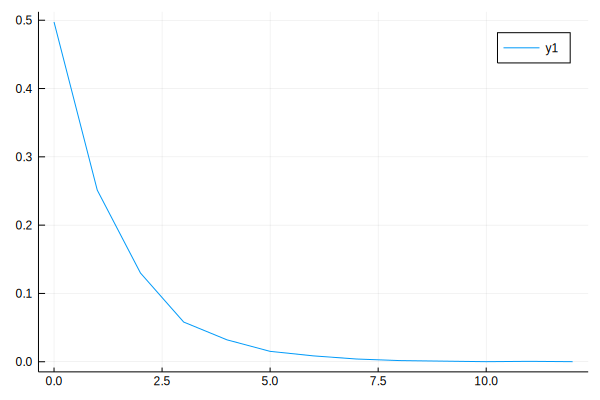

In [125]:
plot(ks,probs)

This seems to be an exponential distribution. 

## Exercise 3: Epidemic model

1. Add recovery to your model using an additional
parameter `p_R` in the `step!` and related functions.
Each agent should check if it is infected, and if so
it recovers with probability $p_R$ at each step.

    The function `simulation` should return vectors `Ss`, `Is` and `Rs` giving the time evolution of the numbers of $S$, $I$ and $R$, as well as the probability distribution of number of people infected.

In [129]:
function infection_simulation(N::Int64,p_i::Float64,p_r::Float64,T::Int64)
    agents = [Agent() for i in 1:N]
    init_infected = rand((1:N))
    agents[init_infected].status = I
    Is = [0]
    Ss = [N]
    Rs = [0]
    for i in 1:T
        sweep!(agents,p_i)
        inf = count([agent.status == I for agent in agents])
        push!(Is,inf)
        healthy = count([agent.status == S for agent in agents])
        push!(Ss,healthy)
        rec = count([agent.status == R for agent in agents])
        push!(Rs,rec)
        for agent in agents
            if agent.status == I && rand() < p_r
                agent.status = R
            end
        end
    end
    return [agent.num_infected for agent in agents], Ss, Is, Rs 
end

infection_simulation (generic function with 2 methods)

2. Run the simulation with $N=1000$, $p_I = 0.1$ and $p_R = 0.01$ for time $T=1000$. Plot $S$, $I$ and $R$ as a function of time. You should see graphs that look familiar from the internet, with an epidemic outbreak, i.e. a significant fraction of infectious agents after a short time, which then recover.

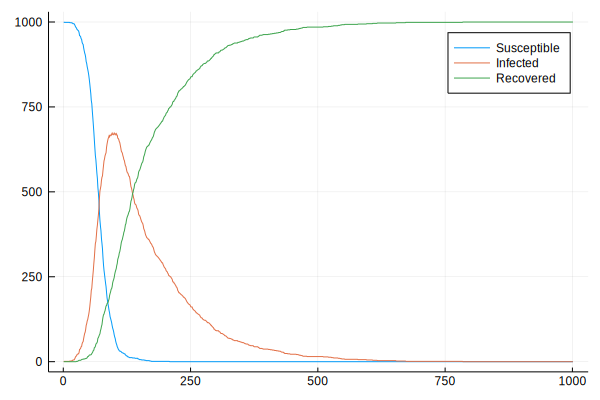

In [130]:
data, Ss, Is, Rs = infection_simulation(1000,0.1,0.01,1000)
plot(Ss, label="Susceptible")
plot!(Is, label="Infected")
plot!(Rs, label = "Recovered")

3. Plot the distribution of `num_infected`. Does it have a recognisable shape?

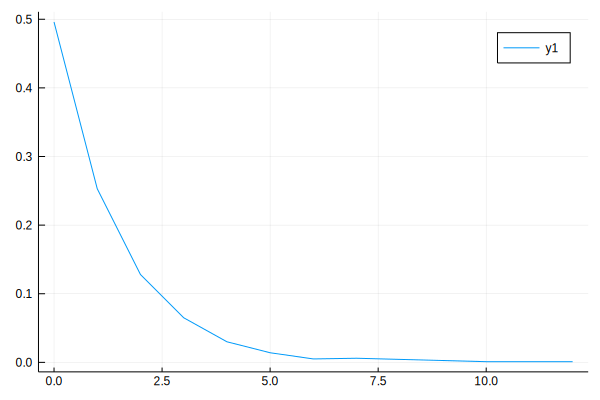

In [131]:
ks,probs = probability_distribution(data)
plot(ks,probs)

4. Run the simulation 50 times and plot $I$ as a function of time for each, together with the mean over the 50 simulations (as you did in Exercise 2).

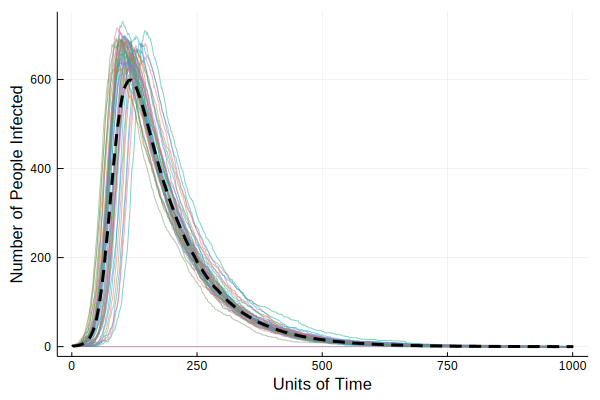

In [132]:
num_runs = 50
results = [infection_simulation(1000,0.1,0.01,1000)[3] for i in 1:num_runs]
p = plot(leg=false)
xlabel!("Units of Time")
ylabel!("Number of People Infected")
for series in results
    plot!(series,alpha=0.5)
end
mean_traj = mean(results)
plot!(mean_traj,lw=3,linestyle=:dash,color=:black)

5. Describe 3 ways in which you could characterize the magnitude of the epidemic. Find these quantities for one of the runs of your simulation.

3 ways we could characterize the epidemic by:
1. peak number of infections
2. time until peak of infections
3. time from first infection until 0 susceptible

In [134]:
num_infected, Ss, Is, Rs = infection_simulation(1000,0.1,0.01,1000)
char_1 = maximum(Is)
char_2 = findmax(Is)
char_3 = findmin(Ss)

653(653, 88)(0, 204)

In [135]:
print("Maximum number of infections is ", char_1)

Maximum number of infections is 653

In [137]:
print("Time until max number of infections (", char_2[1], ") is ", char_2[2] ," days")

Time until max number of infections (653) is 88 days

In [139]:
print("Time from first infection until 0 susceptible is ", char_3[2] ," days")

Time from first infection until 0 susceptible is 204 days